# Analyse des émissions de co2 en fonction de différents paramètres de véhicules

## PARTIE 2 : Modélisation

## Sommaire

1. [Prétraitement des données](#1.Pretraitement-donnees)
   - [Importation des packages et bibliothèques](#importation-des-packages-et-bibliotheques)
   - [Importation des données](#importation-des-donnees)
   - [Séléction des premières données](#premieres-donnees)
   - [Réencodage](#Reencodage)
   - [Séparation des données](#Séparation)
   - [Standardisation](#Standardisation)
2. [Premiers modèles](#2.Premiers-modeles)
   - [Modèles simples](#Modeles-simples)
   - [Rééchantillonage des données](#Reechantillonage)
   - [Séléction des variables](#Selection-variables)
   - [GridSearchCV](#Gridsearchcv)  
3. [Deep Learning](#4.Deep-learning)


Nous avons maintenant un jeu de données tout propre. Nous commencerons dans un premier temps à utiliser ces données sur des modèles simples tels que des RandomForest puis, nous essaierons des modèles de Deep Learning afin de trouver le modèle de prédiciton le plus performant.

## 1. Prétraitement des données
<a id="1.Prétraitement-donnees"></a>

### Importation des packages et bibliothèques
<a id="importation-des-packages-et-bibliotheques"></a>

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm.notebook import *

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Importation des données
<a id="importation-des-donnees"></a>

In [58]:
# Chargement du fichier csv
df=pd.read_csv("Donnees_propres.csv")

# Affichage des 3 premières lignes et des infos du dataframe 
display(df.head(3))
display(df.info())

,lib_mrq,lib_mod_doss,lib_mod,dscom,hybride,puiss_admin_98,puiss_max,conso_urb,conso_exurb,conso_mixte,...,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,Carrosserie,gamme,carburant,typ_boite,nb_rapp,category
0,ALFA-ROMEO,159,159,159 1750 Tbi (200ch),non,12,147.0,11.3,5.8,7.8,...,0.002,1505,1505,715/2007*692/2008EURO5,BERLINE,MOY-SUPER,Essence,Manuelle,6,E
1,ALFA-ROMEO,159,159,159 1750 Tbi (200ch),non,12,147.0,11.5,6.0,8.0,...,0.002,1555,1555,715/2007*692/2008EURO5,BERLINE,MOY-SUPER,Essence,Manuelle,6,E
2,ALFA-ROMEO,159,159,159 2.0 JTDm (136ch),non,7,100.0,6.6,4.2,5.1,...,0.001,1565,1565,715/2007*692/2008EURO5,BERLINE,MOY-SUPER,Gazoil,Manuelle,6,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52308 entries, 0 to 52307
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lib_mrq          52308 non-null  object 
 1   lib_mod_doss     52308 non-null  object 
 2   lib_mod          52308 non-null  object 
 3   dscom            52308 non-null  object 
 4   hybride          52308 non-null  object 
 5   puiss_admin_98   52308 non-null  int64  
 6   puiss_max        52308 non-null  float64
 7   conso_urb        52308 non-null  float64
 8   conso_exurb      52308 non-null  float64
 9   conso_mixte      52308 non-null  float64
 10  co2              52308 non-null  float64
 11  co_typ_1         52308 non-null  float64
 12  nox              52308 non-null  float64
 13  ptcl             52308 non-null  float64
 14  masse_ordma_min  52308 non-null  int64  
 15  masse_ordma_max  52308 non-null  int64  
 16  champ_v9         52308 non-null  object 
 17  Carrosserie 

None

### Séléction des premières données
<a id="premieres-donnees"></a>


On supprime les colonnes qui contiennent des informations sur la marque ou le constructeur :
lib_mrq, lib_mod_doss, lib_mod_ dscom ainsi que la variable champ_v9, co2 (nous avons les categories), puiss_admin_98, co_typ_1 


In [59]:
to_drop = ['lib_mrq', 'lib_mod_doss', 'lib_mod', 'dscom', 'champ_v9', 'co2', 'puiss_admin_98', 'co_typ_1',
           'conso_urb', 'conso_exurb', 'conso_mixte']

df_clear = df.drop(to_drop, axis = 1)

### Réencodage
<a id="Reencodage"></a>

Avant de réencoder les variables, nous regardons les variables catégorielles pour voir combien chacune d'elle contient de modalités différentes.

In [60]:
# On récupère les colonnes de type Object
colonnes_object = df_clear.select_dtypes(include='object')

# On calcule le nombre de modalités de chacune de ces variables
categories_uniques = colonnes_object.nunique()
print(categories_uniques)

hybride         2
Carrosserie    11
gamme           6
carburant       4
typ_boite       3
category        7
dtype: int64


Nous avons 6 Variables catégorielles à réencoder

Reencodage des variables categorielles

In [61]:
# Variable Hybride qui contient 2 modalités : oui et non

df_clear['hybride'] = df_clear['hybride'].replace({'oui':1, 'non': 0})
display('hybride', df_clear['hybride'].unique())

# Variable cible categoy
# On créé un dictionnaire qui contient les changements souhaités
Etiquette = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df_clear['category'] = df_clear['category'].replace(Etiquette)

# On vérifie la variable 'category'
display('category', df_clear['category'].unique())

# Réencodage des autres variables catégorielles à l'aide d'un get_dummies
df_encoded = pd.get_dummies(df_clear, dtype='int')

# On vérifie que le réencodage s'est bien passé
display(df_encoded.info())
display(df_encoded.head())


'hybride'

array([0, 1])

'category'

array([4, 2, 3, 1, 0, 5, 6])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52308 entries, 0 to 52307
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   hybride                          52308 non-null  int64  
 1   puiss_max                        52308 non-null  float64
 2   nox                              52308 non-null  float64
 3   ptcl                             52308 non-null  float64
 4   masse_ordma_min                  52308 non-null  int64  
 5   masse_ordma_max                  52308 non-null  int64  
 6   nb_rapp                          52308 non-null  int64  
 7   category                         52308 non-null  int64  
 8   Carrosserie_BERLINE              52308 non-null  int64  
 9   Carrosserie_BREAK                52308 non-null  int64  
 10  Carrosserie_CABRIOLET            52308 non-null  int64  
 11  Carrosserie_COMBISPACE           52308 non-null  int64  
 12  Carrosserie_COMBIS

None

,hybride,puiss_max,nox,ptcl,masse_ordma_min,masse_ordma_max,nb_rapp,category,Carrosserie_BERLINE,Carrosserie_BREAK,...,gamme_MOY-INFER,gamme_MOY-SUPER,gamme_SUPERIEURE,carburant_Essence,carburant_Essence/Elec,carburant_Gasoil/Elec,carburant_Gazoil,typ_boite_Auto,typ_boite_Manuelle,typ_boite_Var_continue
0,0,147.0,0.032,0.002,1505,1505,6,4,1,0,...,0,1,0,1,0,0,0,0,1,0
1,0,147.0,0.032,0.002,1555,1555,6,4,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0,100.0,0.149,0.001,1565,1565,6,2,1,0,...,0,1,0,0,0,0,1,0,1,0
3,0,100.0,0.149,0.001,1565,1565,6,2,1,0,...,0,1,0,0,0,0,1,0,1,0
4,0,125.0,0.164,0.001,1565,1565,6,2,1,0,...,0,1,0,0,0,0,1,0,1,0


### Séparation des données
<a id="Séparation"></a>

On sépare les données en jeu de test et d'entrainement

In [62]:
X = df_encoded.drop(columns ='category', axis = 1)
y= df_encoded['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

### Standardisation
<a id="Standardisation"></a>

On va standardiser les données avec un StandarScaler()

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

## 2. Premiers modèles
<a id="Premiers-modeles"></a>

## 2.Premiers modèles
<a id="2.Premiers-modeles"></a>

### Modèles simples
<a id="Modeles-simples"></a>

#### RandomForest

score données train 0.8939922573244754
score données test 0.8729688396100173
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        31
           1       0.83      0.88      0.86       249
           2       0.87      0.80      0.83       427
           3       0.79      0.77      0.78       324
           4       0.80      0.87      0.83      3333
           5       0.92      0.88      0.90      5968
           6       1.00      0.93      0.96       130

    accuracy                           0.87     10462
   macro avg       0.87      0.85      0.86     10462
weighted avg       0.88      0.87      0.87     10462



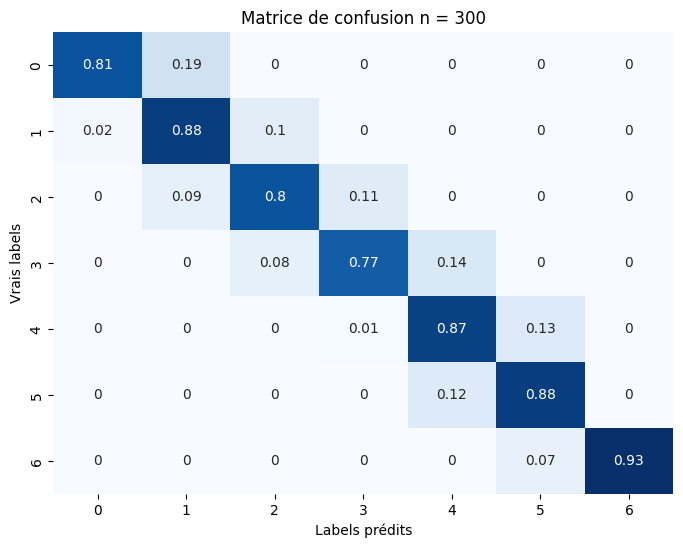

In [64]:
# Modèle
model1 = RandomForestClassifier(n_estimators=300, random_state=42)
model1.fit(X_train_scaled, y_train)

# Prediction
y_pred = model1.predict(X_test_scaled)


# Résultats
print('score données train', model1.score(X_train_scaled, y_train))
print('score données test', model1.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))


# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion n = 300")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()


#### XGBoost

score données train 0.8928690914304832
score données test 0.8761231122156375
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        31
           1       0.84      0.90      0.87       249
           2       0.86      0.81      0.84       427
           3       0.79      0.78      0.79       324
           4       0.79      0.89      0.84      3333
           5       0.94      0.87      0.91      5968
           6       0.99      0.93      0.96       130

    accuracy                           0.88     10462
   macro avg       0.87      0.86      0.86     10462
weighted avg       0.88      0.88      0.88     10462



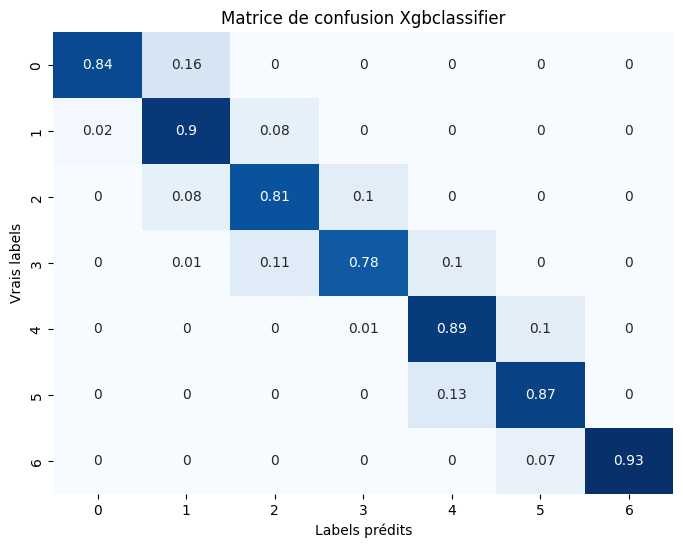

In [65]:
# Modèle
model2 = XGBClassifier(eval_metric="merror", use_label_encoder=False)
model2.fit(X_train_scaled, y_train)

# Prediction
y_pred = model2.predict(X_test_scaled)

# Résultats
print('score données train', model2.score(X_train_scaled, y_train))
print('score données test', model2.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion Xgbclassifier")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

Random forest avec l'argument class_weight='balanced'

score données train 0.8847440615590498
score données test 0.8698145670043969
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        31
           1       0.82      0.87      0.84       249
           2       0.87      0.79      0.83       427
           3       0.70      0.87      0.78       324
           4       0.78      0.91      0.84      3333
           5       0.96      0.85      0.90      5968
           6       0.75      0.99      0.85       130

    accuracy                           0.87     10462
   macro avg       0.80      0.87      0.83     10462
weighted avg       0.88      0.87      0.87     10462



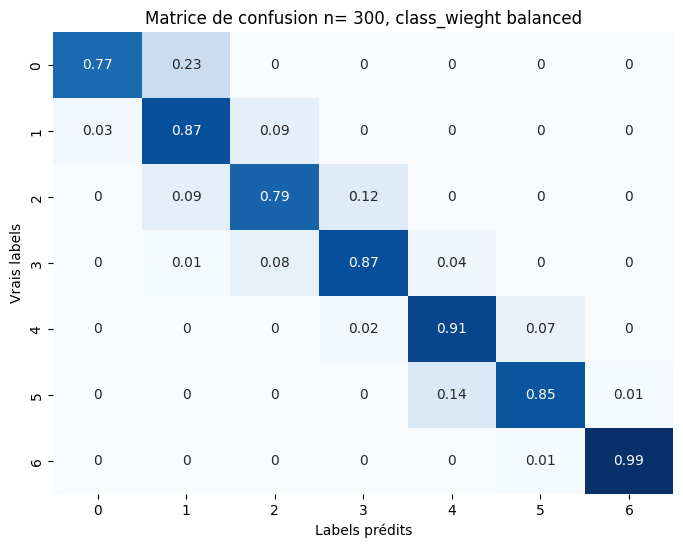

In [66]:
# Modele avec l'argument class_weight='balanced'
model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Prediction
y_pred = model.predict(X_test_scaled)

# Résultats
print('score données train', model.score(X_train_scaled, y_train))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))


# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion n= 300, class_wieght balanced")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

Random forest avec plus de branches : 500

score données train 0.8939922573244754
score données test 0.872108583444848
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        31
           1       0.83      0.86      0.85       249
           2       0.85      0.81      0.83       427
           3       0.79      0.77      0.78       324
           4       0.80      0.86      0.83      3333
           5       0.92      0.89      0.90      5968
           6       1.00      0.93      0.96       130

    accuracy                           0.87     10462
   macro avg       0.87      0.84      0.85     10462
weighted avg       0.87      0.87      0.87     10462



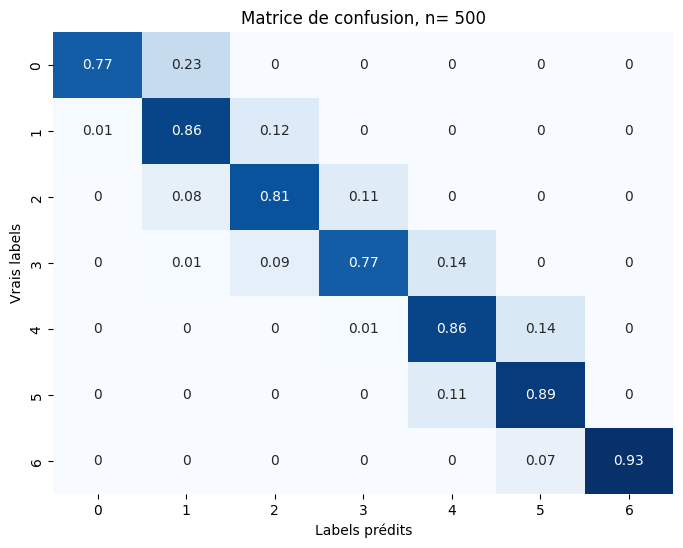

In [67]:
# Modèle
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train_scaled, y_train)

# Prediction
y_pred = model.predict(X_test_scaled)


# Résultats
print('score données train', model.score(X_train_scaled, y_train))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion, n= 500")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

### Rééchantillonage des données
<a id="Reechantillonage"></a>

#### SMOTE

In [68]:
# Rééchantillonnage
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

#### RandomForest avec SMOTE

score données train 0.9498455054517042
score données test 0.8700057350411011
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        31
           1       0.80      0.86      0.83       249
           2       0.86      0.77      0.81       427
           3       0.71      0.85      0.77       324
           4       0.78      0.91      0.84      3333
           5       0.96      0.85      0.90      5968
           6       0.78      0.96      0.86       130

    accuracy                           0.87     10462
   macro avg       0.80      0.85      0.82     10462
weighted avg       0.88      0.87      0.87     10462



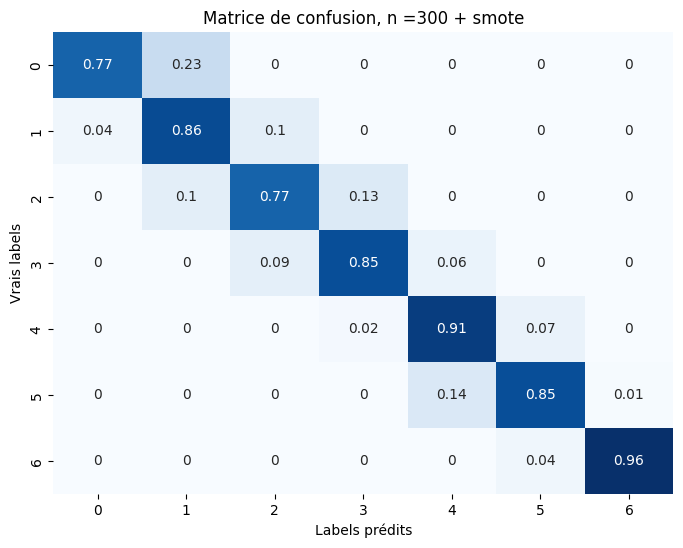

In [69]:

# Modele
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_smote, y_train_smote)

# Prediction
y_pred = model.predict(X_test_scaled)

# Résultats
print('score données train', model.score(X_train_smote, y_train_smote))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion, n =300 + smote")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

#### XGBoost avec SMOTE

score données train 0.9410316210680841
score données test 0.8704836551328617
              precision    recall  f1-score   support

           0       0.64      0.74      0.69        31
           1       0.80      0.86      0.83       249
           2       0.88      0.77      0.82       427
           3       0.71      0.88      0.79       324
           4       0.78      0.91      0.84      3333
           5       0.96      0.85      0.90      5968
           6       0.71      0.99      0.83       130

    accuracy                           0.87     10462
   macro avg       0.78      0.86      0.81     10462
weighted avg       0.88      0.87      0.87     10462



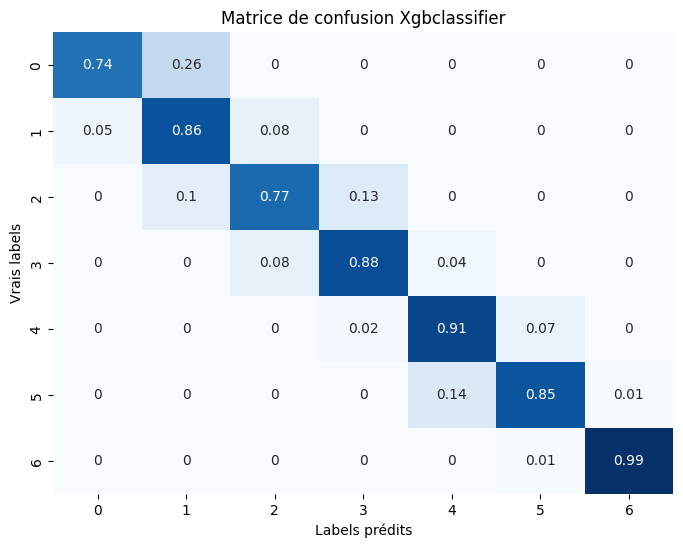

In [70]:
# Modèle
model = XGBClassifier(eval_metric="merror", use_label_encoder=False)
model.fit(X_train_smote, y_train_smote)

# Prediction
y_pred = model.predict(X_test_scaled)

# Résultats
print('score données train', model.score(X_train_smote, y_train_smote))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion Xgbclassifier")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

#### Undersampling

In [71]:
# Rééchantillonnage
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_scaled, y_train)

#### RandomForest avec UnderSampling


score données train 0.9655419956927495
score données test 0.8129420760848786
              precision    recall  f1-score   support

           0       0.47      1.00      0.64        31
           1       0.69      0.74      0.72       249
           2       0.81      0.65      0.72       427
           3       0.52      0.87      0.65       324
           4       0.76      0.79      0.78      3333
           5       0.91      0.83      0.87      5968
           6       0.42      0.99      0.59       130

    accuracy                           0.81     10462
   macro avg       0.65      0.84      0.71     10462
weighted avg       0.83      0.81      0.82     10462



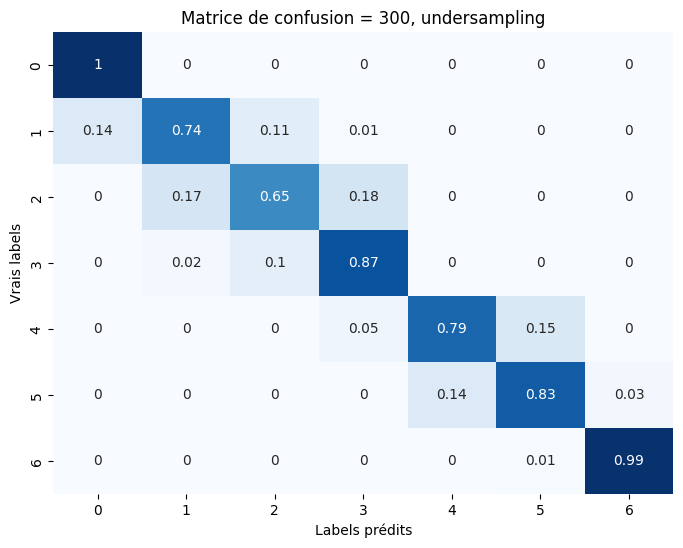

In [72]:
# Modèle
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Prediction
y_pred = model.predict(X_test_scaled)


# Résultats
print('score données train', model.score(X_train_resampled, y_train_resampled))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion = 300, undersampling")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

# Moins précis que le modele avec les données non rééchantillonées

#### XGBoost avec UnderSampling

score données train 0.9655419956927495
score données test 0.8134199961766393
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        31
           1       0.71      0.75      0.73       249
           2       0.78      0.65      0.71       427
           3       0.57      0.87      0.68       324
           4       0.76      0.78      0.77      3333
           5       0.90      0.84      0.87      5968
           6       0.42      0.99      0.59       130

    accuracy                           0.81     10462
   macro avg       0.66      0.84      0.72     10462
weighted avg       0.83      0.81      0.82     10462



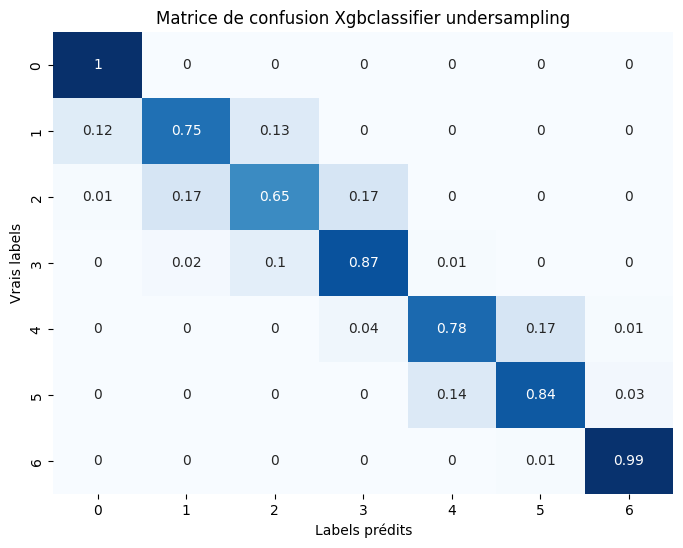

In [73]:
# Modele
model = XGBClassifier(eval_metric="merror", use_label_encoder=False)
model.fit(X_train_resampled, y_train_resampled)

# Prediction
y_pred = model.predict(X_test_scaled)

# Résultats
print('score données train', model.score(X_train_resampled, y_train_resampled))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion Xgbclassifier undersampling")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

## Séléction des variables
<a id="Selecion-variables"></a>

### Variables qui ont le plus d'importance
<a id="var-plus-importance"></a>
On teste le premier modèle (RandomForest avec 300 branches) avec les variables qui ont le plus d'importance.  
On récupère les données et on recommence le traitement comme précédement.

                            Feature  Importance
2                               nox    0.243543
5                   masse_ordma_max    0.146017
4                   masse_ordma_min    0.116566
6                           nb_rapp    0.084116
1                         puiss_max    0.078076
29               typ_boite_Manuelle    0.070816
28                   typ_boite_Auto    0.068786
13              Carrosserie_MINIBUS    0.037828
3                              ptcl    0.037507
21                  gamme_MOY-INFER    0.020982
22                  gamme_MOY-SUPER    0.019607
7               Carrosserie_BERLINE    0.017423
27                 carburant_Gazoil    0.010351
24                carburant_Essence    0.009667
20                       gamme_LUXE    0.009000
23                 gamme_SUPERIEURE    0.006512
17  Carrosserie_TS TERRAINS/CHEMINS    0.005283
8                 Carrosserie_BREAK    0.003996
19                 gamme_INFERIEURE    0.002635
9             Carrosserie_CABRIOLET    0

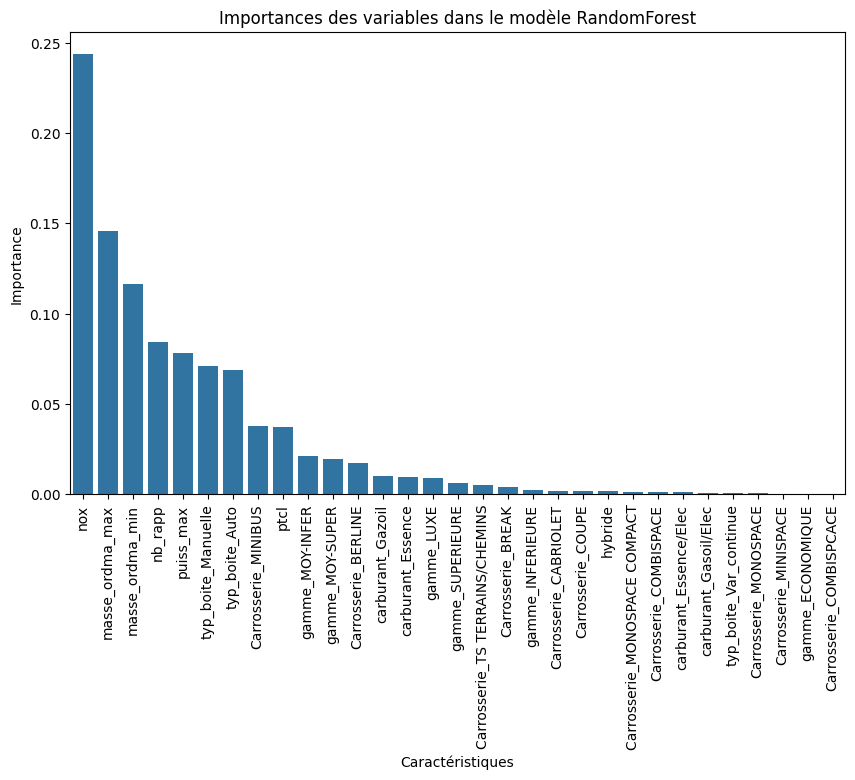

In [74]:
# On récupère le modèle 1 et on regarde les données ayant le plus d'importance

# On trie les variables par importance
importances = model1.feature_importances_
features = X_train.columns  
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Affichage sous forme de graphe
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=importance_df)
plt.title('Importances des variables dans le modèle RandomForest')
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.xticks(rotation=90)  
plt.show()

Les données ayant le plus d'importance sont : 'nox', 'masse_ordma_min', 'masse_ordma_max', 'nb_rapp', 'puiss_max'.  
On récupère ces données et on recommence le traitement des données avec ces variables.

In [75]:
# Récupération des données
df=pd.read_csv("Donnees_propres.csv")
X = df[['nox', 'masse_ordma_min', 'masse_ordma_max', 'nb_rapp', 'puiss_max']]

# Réencodage
X_encoded = pd.get_dummies(X, dtype='int')

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

#### RandomForest

score données train 0.8925106342302729
score données test 0.8678073026190021
              precision    recall  f1-score   support

           0       0.77      0.65      0.70        31
           1       0.79      0.87      0.83       249
           2       0.82      0.78      0.80       427
           3       0.76      0.71      0.73       324
           4       0.79      0.87      0.83      3333
           5       0.93      0.88      0.90      5968
           6       0.99      0.93      0.96       130

    accuracy                           0.87     10462
   macro avg       0.83      0.81      0.82     10462
weighted avg       0.87      0.87      0.87     10462



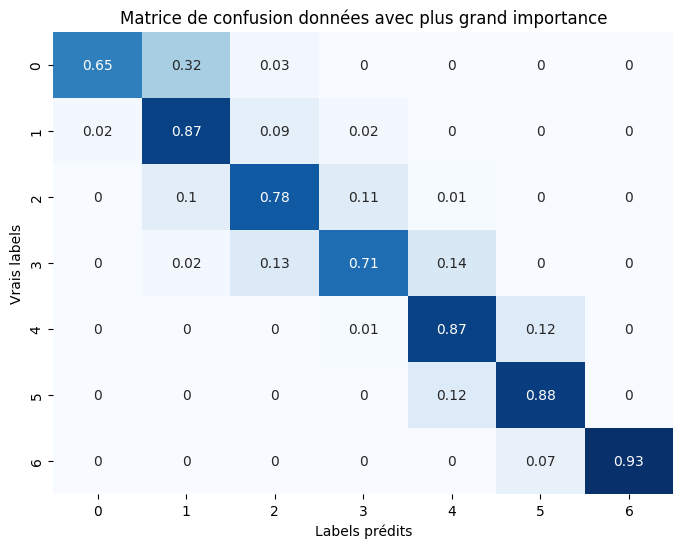

In [76]:
# Modele
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_scaled, y_train)

# Prediction
y_pred = model.predict(X_test_scaled)

# Résultats
print('score données train', model.score(X_train_scaled, y_train))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion données avec plus grand importance")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

### Selection des données purement caracteristiques de la voiture

In [77]:
# Récupération des données
df=pd.read_csv("Donnees_propres.csv")
df_caract = df[['carburant','hybride','masse_ordma_min','masse_ordma_max',
                "puiss_max",'Carrosserie','typ_boite','nb_rapp', 'gamme']]

# Réencodage
df_caract['hybride'] = df_caract['hybride'].replace({'oui':1, 'non': 0})
df_encoded = pd.get_dummies(df_caract, dtype='int')

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=12)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

#### RandomForest

score données train 0.8337475505424652
score données test 0.8124641559931179
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        31
           1       0.77      0.85      0.81       249
           2       0.84      0.76      0.80       427
           3       0.76      0.74      0.75       324
           4       0.77      0.67      0.72      3333
           5       0.83      0.90      0.86      5968
           6       1.00      0.92      0.96       130

    accuracy                           0.81     10462
   macro avg       0.80      0.77      0.79     10462
weighted avg       0.81      0.81      0.81     10462



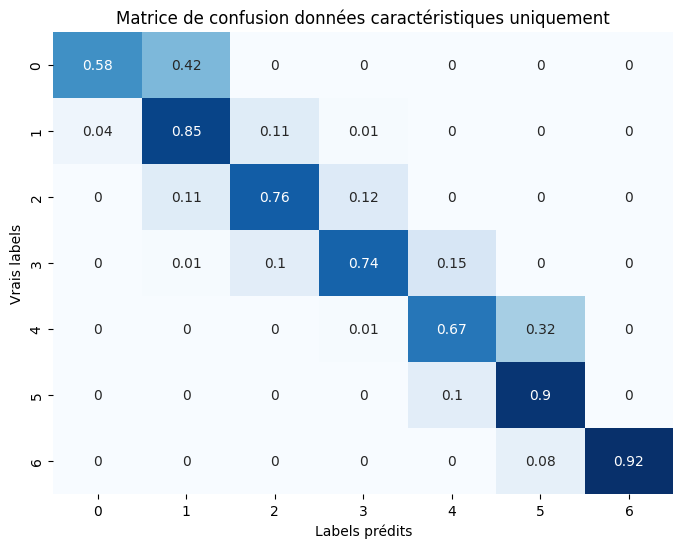

In [78]:
# Modele
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_scaled, y_train)

# Prediction
y_pred = model.predict(X_test_scaled)

# Résultats
print('score données train', model.score(X_train_scaled, y_train))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion données caractéristiques uniquement")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

On regarde quelles données caractéristiques ont le plus d'importance.

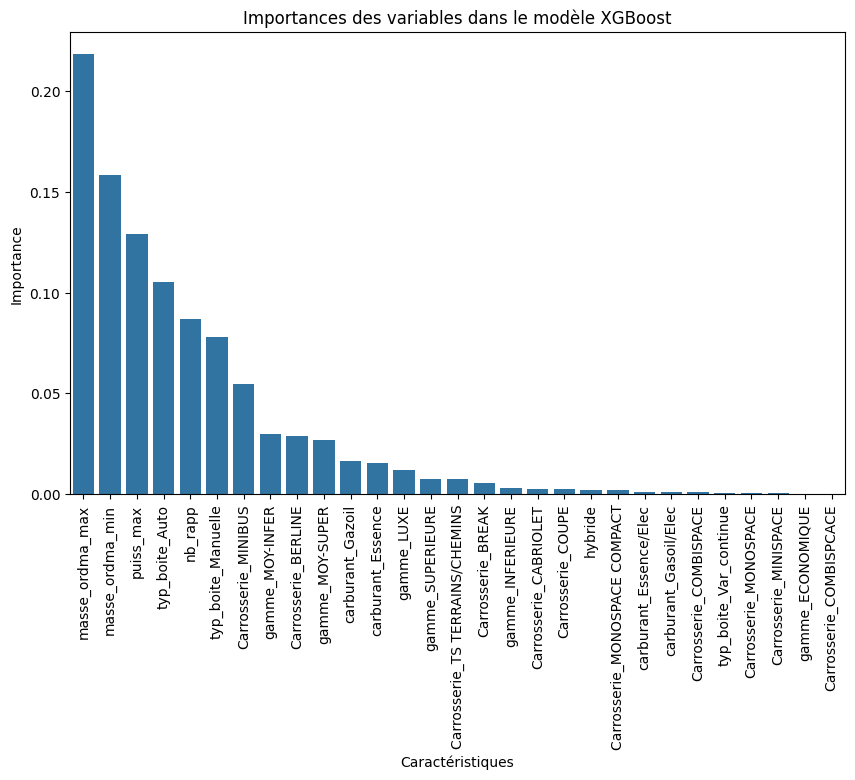

In [79]:
# Trie des variables par importance
importances = model.feature_importances_
features = X_train.columns  
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Affichage sous forme de graphe
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=importance_df)
plt.title('Importances des variables dans le modèle XGBoost')
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.xticks(rotation=90)  
plt.show()

Les 5 caractéristiques les plus importantes sont : 'masse_ordma_min','masse_ordma_max',"puiss_max",'typ_boite','nb_rapp'.  
On fait de même que précédement.

In [80]:
df_caract = df[['masse_ordma_min','masse_ordma_max',"puiss_max",'typ_boite','nb_rapp']]

# Réencodage
df_encoded = pd.get_dummies(df_caract, dtype='int')

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=12)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

#### RandomForest

score données train 0.8286335611527984
score données test 0.8072070349837507
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        31
           1       0.75      0.79      0.77       249
           2       0.81      0.74      0.77       427
           3       0.70      0.73      0.71       324
           4       0.79      0.64      0.70      3333
           5       0.82      0.91      0.86      5968
           6       0.99      0.92      0.96       130

    accuracy                           0.81     10462
   macro avg       0.78      0.76      0.77     10462
weighted avg       0.81      0.81      0.80     10462



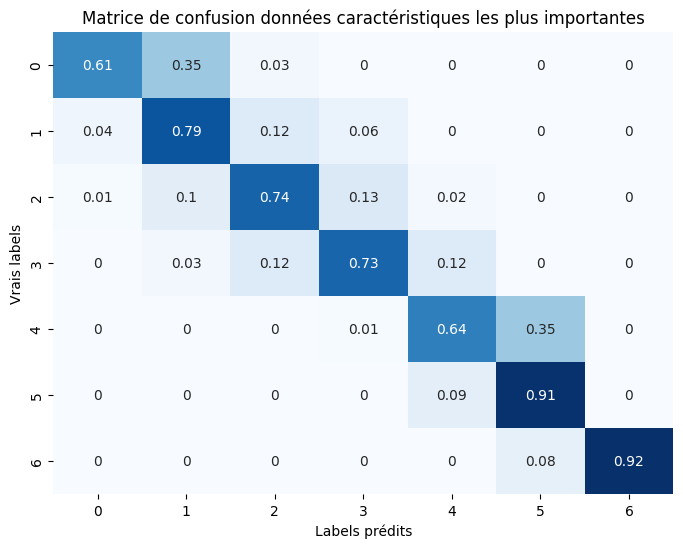

In [81]:
# Modele
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_scaled, y_train)

# Prediction
y_pred = model.predict(X_test_scaled)

# Résultats
print('score données train', model.score(X_train_scaled, y_train))
print('score données test', model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion données caractéristiques les plus importantes")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

### GridSearchCV
<a id="Gridsearchcv"></a>

In [82]:
# Récupération des données initiales déjà réencodées
df_encoded = pd.get_dummies(df_clear, dtype='int')
X = df_encoded.drop(columns ='category', axis = 1)
y= df_encoded['category']

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

{'max_depth': 100, 'n_estimators': 500}
score données train 0.8939922573244754
score données test 0.8730644236283693
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        31
           1       0.84      0.87      0.85       249
           2       0.86      0.81      0.83       427
           3       0.78      0.78      0.78       324
           4       0.80      0.86      0.83      3333
           5       0.92      0.89      0.91      5968
           6       1.00      0.93      0.96       130

    accuracy                           0.87     10462
   macro avg       0.87      0.84      0.86     10462
weighted avg       0.88      0.87      0.87     10462



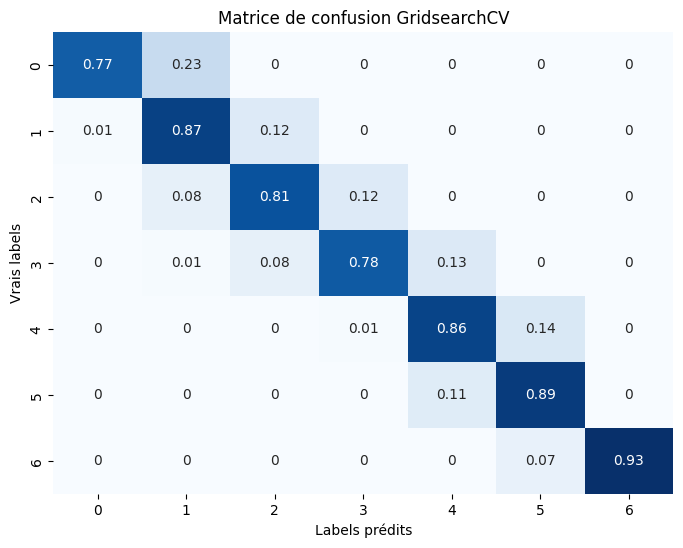

In [83]:
# Paramètres à tester
params = {'n_estimators': [50, 100, 300, 200, 500], 'max_depth': [50, 70, 100, 200, 300]}

# Modèle
model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs= -1)
grid_search.fit(X_train_scaled, y_train)

# Affichage des meilleurs paramètres
print(grid_search.best_params_)

# Prediction avec le meilleur modèle
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Résultats
print('score données train', best_model.score(X_train_scaled, y_train))
print('score données test', best_model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion GridsearchCV")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

## 3.Deep Learning
<a id="Deep-learning"></a>

### MLP Classifier

score données train 0.6185537446828848
score données test 0.6167080864079526
              precision    recall  f1-score   support

           0       0.24      0.58      0.34        31
           1       0.80      0.16      0.26       249
           2       0.53      0.59      0.56       427
           3       0.55      0.26      0.35       324
           4       0.66      0.65      0.65      3333
           5       0.80      0.85      0.83      5968
           6       0.27      0.07      0.11       130

    accuracy                           0.73     10462
   macro avg       0.55      0.45      0.44     10462
weighted avg       0.73      0.73      0.72     10462



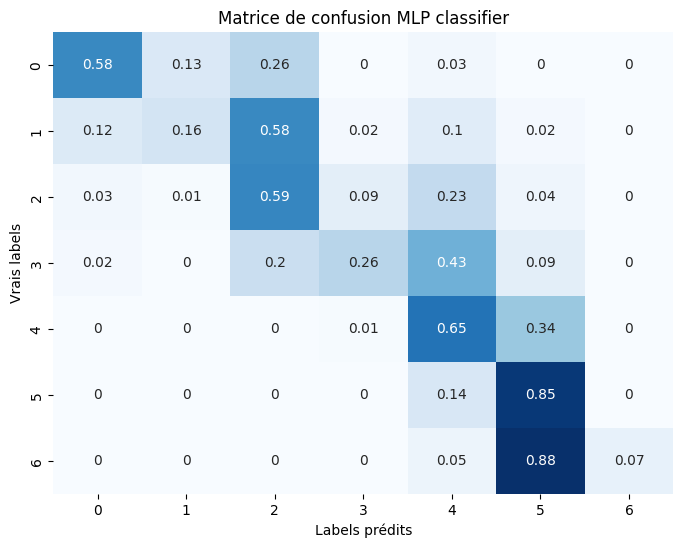

In [84]:
# Modèle
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42, alpha=0.001, solver='adam',early_stopping=True)
mlp.fit(X_train, y_train)

# Prédictions avec le modèle
y_pred = mlp.predict(X_test)

# Résultats
print('score données train', mlp.score(X_train_scaled, y_train))
print('score données test', mlp.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred, normalize='true').round(2)

plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion MLP classifier")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

### Modèle séquentiel avec une seule couche cachée

Epoch 1/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5698 - loss: 1.2293 - val_accuracy: 0.7503 - val_loss: 0.5488
Epoch 2/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7573 - loss: 0.5274 - val_accuracy: 0.7599 - val_loss: 0.4934
Epoch 3/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7664 - loss: 0.4780 - val_accuracy: 0.7711 - val_loss: 0.4701
Epoch 4/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7763 - loss: 0.4590 - val_accuracy: 0.7742 - val_loss: 0.4577
Epoch 5/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7796 - loss: 0.4482 - val_accuracy: 0.7806 - val_loss: 0.4475
Epoch 6/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7826 - loss: 0.4417 - val_accuracy: 0.7792 - val_loss: 0.4423
Epoch 7/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7845 - loss: 0.4305 - val_accuracy: 0.7812 - val_loss: 0.4361
Epoch 8/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7852 - loss: 0.4284 - 

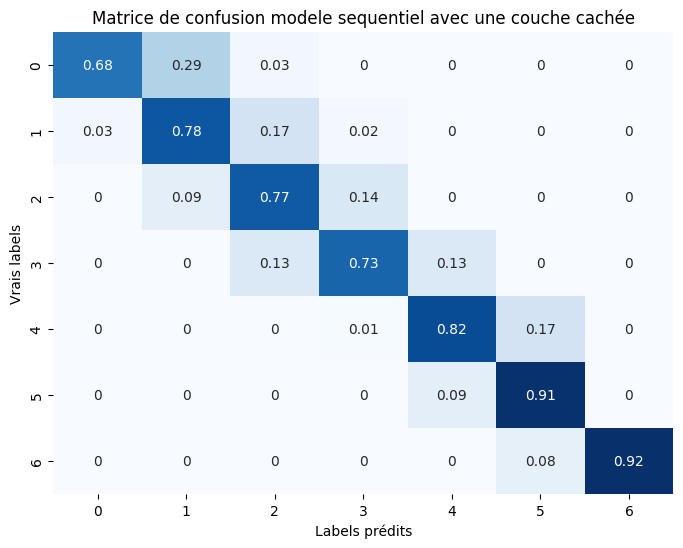

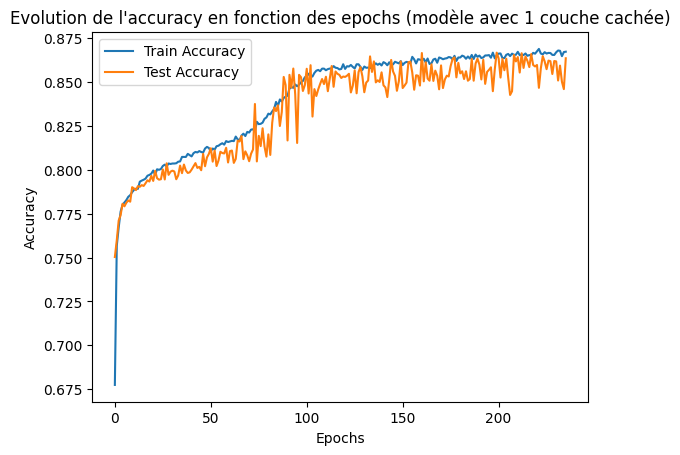

In [85]:
# Création du modèle séquentiel
model = Sequential()

# Nombre de features
num_features = X_train_scaled.shape[1]

# Ajout des couches
model.add(Dense(units=64, activation="relu", input_shape=(num_features,)))
model.add(Dense(units=7, activation="softmax"))

# Compilation
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Ajout du callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveille la perte sur l'ensemble de validation
    patience=20,         # Nombre d'epochs sans amélioration avant d'arrêter
    restore_best_weights=True,  # Restaure les poids du meilleur modèle trouvé
    verbose=1
)

# Entraînement
history = model.fit(
    X_train_scaled, y_train,
    epochs=1000,                 # Nombre maximal d'epochs
    batch_size=128,             # Taille des batchs
    validation_split=0.2,       # 20% des données utilisées pour la validation
    callbacks=[early_stopping]  # Ajout de l'early stopping
)


# Évaluation
test_pred = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_test)
test_pred_class = test_pred.argmax(axis=1)

# Resultats 
print(classification_report(y_test, test_pred_class))

cnf_matrix = confusion_matrix(y_test, test_pred_class, normalize='true').round(2)
plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion modele sequentiel avec une couche cachée")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

# Graphe d'évolution de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("Evolution de l'accuracy en fonction des epochs (modèle avec 1 couche cachée)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Modèle sequentiel avec plusieurs couches et la fonction d'activation Relu

Epoch 1/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6971 - loss: 0.8106 - val_accuracy: 0.7750 - val_loss: 0.4540
Epoch 2/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7774 - loss: 0.4360 - val_accuracy: 0.7833 - val_loss: 0.4244
Epoch 3/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7845 - loss: 0.4151 - val_accuracy: 0.7885 - val_loss: 0.4142
Epoch 4/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7867 - loss: 0.4044 - val_accuracy: 0.7859 - val_loss: 0.4076
Epoch 5/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7948 - loss: 0.3949 - val_accuracy: 0.7920 - val_loss: 0.3972
Epoch 6/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7951 - loss: 0.3841 - val_accuracy: 0.7952 - val_loss: 0.3918
Epoch 7/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8005 - loss: 0.3784 - val_accuracy: 0.7941 - val_loss: 0.3984
Epoch 8/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8029 - loss: 0.3766 - 

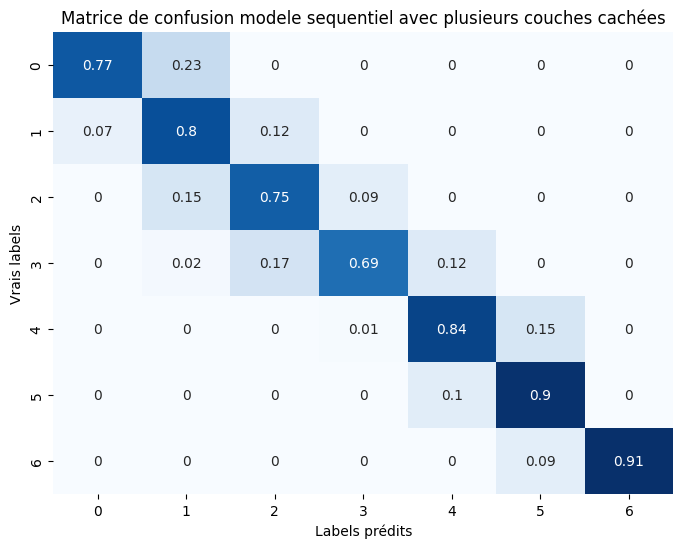

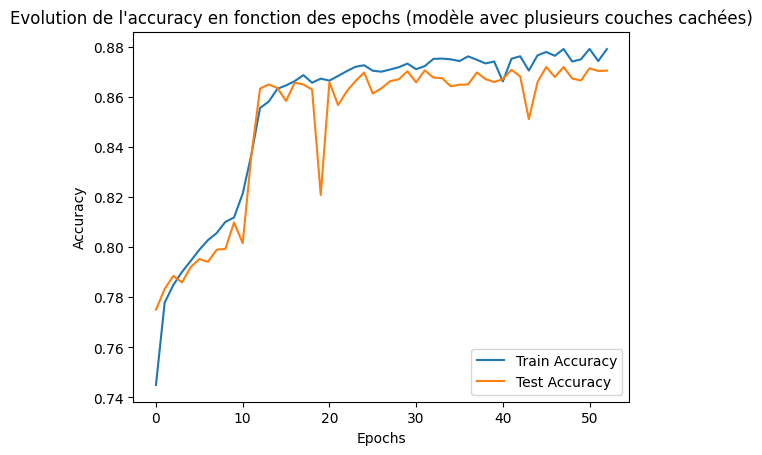

In [86]:
# Création du modèle séquentiel
model = Sequential()

# Nombre de features
num_features = X_train_scaled.shape[1]

# Ajout des couches
model.add(Dense(units=256, activation="relu", input_shape=(num_features,)))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=32, activation="relu"))

model.add(Dense(units=10, activation="softmax"))  # Couche de sortie

# Compilation
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Ajout du callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveille la perte sur l'ensemble de validation
    patience=20,         # Nombre d'epochs sans amélioration avant d'arrêter
    restore_best_weights=True,  # Restaure les poids du meilleur modèle trouvé
    verbose=1
)

# Entraînement
history = model.fit(
    X_train_scaled, y_train,
    epochs=1000,                 # Nombre maximal d'epochs
    batch_size=128,             # Taille des batchs
    validation_split=0.2,       # 20% des données utilisées pour la validation
    callbacks=[early_stopping]  # Ajout de l'early stopping
)


# Prediction
test_pred = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_test)

test_pred_class = test_pred.argmax(axis=1)


# Résultats
print(classification_report(y_test, test_pred_class))

cnf_matrix = confusion_matrix(y_test, test_pred_class, normalize='true').round(2)
plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion modele sequentiel avec plusieurs couches cachées")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

# Graphe d'évolution de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("Evolution de l'accuracy en fonction des epochs (modèle avec plusieurs couches cachées)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Modèle sequentiel avec plusieurs couches et la fonction d'acitvation Leakyrelu

Epoch 1/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6898 - loss: 0.8680 - val_accuracy: 0.7710 - val_loss: 0.4563
Epoch 2/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7795 - loss: 0.4342 - val_accuracy: 0.7784 - val_loss: 0.4493
Epoch 3/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7799 - loss: 0.4226 - val_accuracy: 0.7894 - val_loss: 0.4090
Epoch 4/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7851 - loss: 0.4080 - val_accuracy: 0.7952 - val_loss: 0.4005
Epoch 5/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7975 - loss: 0.3902 - val_accuracy: 0.7857 - val_loss: 0.4063
Epoch 6/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7999 - loss: 0.3843 - val_accuracy: 0.7975 - val_loss: 0.3853
Epoch 7/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8044 - loss: 0.3733 - val_accuracy: 0.8039 - val_loss: 0.3743
Epoch 8/1000
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8105 - loss: 0.3626 - 

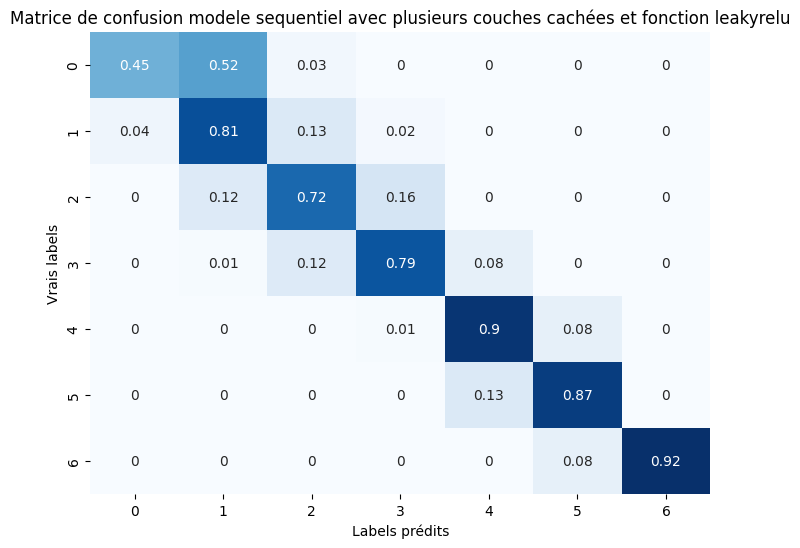

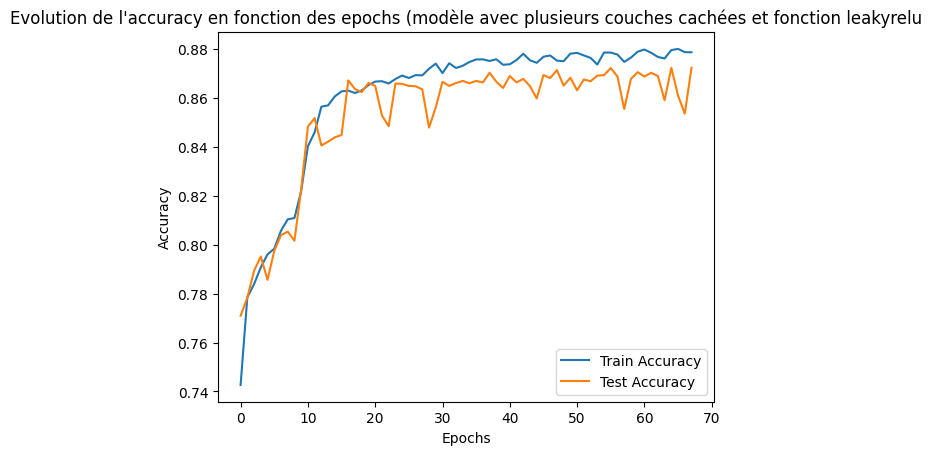

In [87]:
# Création du modèle séquentiel
model = Sequential()

# Nombre de features
num_features = X_train_scaled.shape[1]

# Ajout des couches

model = Sequential()
model.add(Dense(256, input_shape=(num_features,)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))


model.add(Dense(units=10, activation="softmax"))  # Couche de sortie



# Compilation
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Ajout du callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveille la perte sur l'ensemble de validation
    patience=20,         # Nombre d'epochs sans amélioration avant d'arrêter
    restore_best_weights=True,  # Restaure les poids du meilleur modèle trouvé
    verbose=1
)

# Entraînement
history = model.fit(
    X_train_scaled, y_train,
    epochs=1000,                 # Nombre maximal d'epochs
    batch_size=128,             # Taille des batchs
    validation_split=0.2,       # 20% des données utilisées pour la validation
    callbacks=[early_stopping]  # Ajout de l'early stopping
)

# Prédictions
test_pred = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_test)

test_pred_class = test_pred.argmax(axis=1)

# Résultats
print(classification_report(y_test, test_pred_class))

cnf_matrix = confusion_matrix(y_test, test_pred_class, normalize='true').round(2)
plt.figure(figsize=(8, 6))
plt.title("Matrice de confusion modele sequentiel avec plusieurs couches cachées et fonction leakyrelu")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False)
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

# Graphe d'évolution de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("Evolution de l'accuracy en fonction des epochs (modèle avec plusieurs couches cachées et fonction leakyrelu")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Modèle séquentiel avec plusieurs couches cachées et différents nouveaux paramètres

Epoch 1/1000
524/524 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6186 - loss: 1.1923 - val_accuracy: 0.7606 - val_loss: 0.4868 - learning_rate: 0.0010
Epoch 2/1000
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7424 - loss: 0.5338 - val_accuracy: 0.7786 - val_loss: 0.4511 - learning_rate: 0.0010
Epoch 3/1000
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7457 - loss: 0.5072 - val_accuracy: 0.7719 - val_loss: 0.4355 - learning_rate: 0.0010
Epoch 4/1000
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7586 - loss: 0.4798 - val_accuracy: 0.7857 - val_loss: 0.4278 - learning_rate: 0.0010
Epoch 5/1000
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7615 - loss: 0.4595 - val_accuracy: 0.7793 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 6/1000
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7689 - loss: 0.4462 - val_accuracy: 0.7808 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 7/1000
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7718 - l

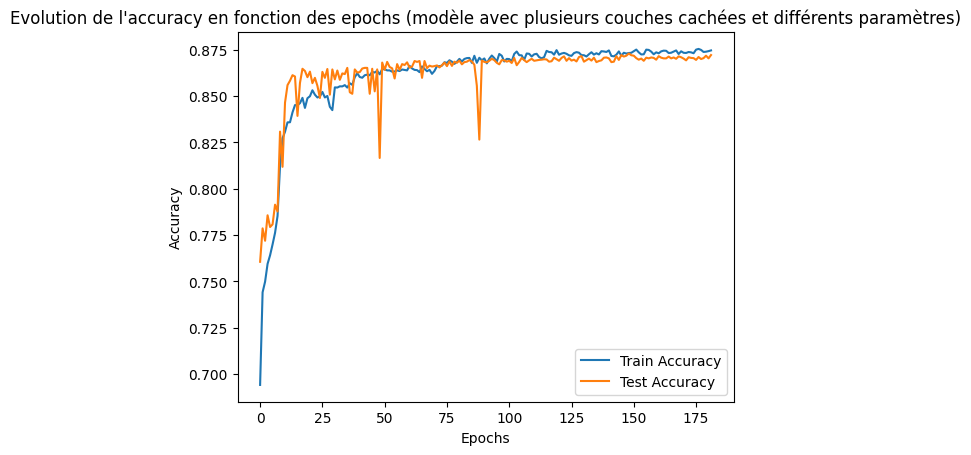

In [91]:
# Création du modèle séquentiel
model = Sequential()

# Nombre de features
num_features = X_train_scaled.shape[1]

# Ajout des couches avec Batch Normalization et Dropout
model.add(Dense(256, activation="relu", input_shape=(num_features,)))
model.add(BatchNormalization())  
model.add(Dropout(0.3))  # Dropout pour éviter l'overfitting

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())

# Couche de sortie
model.add(Dense(10, activation="softmax"))

# Compilation du modèle avec Adam
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Callbacks pour optimiser l'entraînement
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=20,         
    restore_best_weights=True,  
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=10, 
    verbose=1
)

# Entraînement
history = model.fit(
    X_train_scaled, y_train,
    epochs=1000,  
    batch_size=64,  # Taille de batch réduite pour une meilleure généralisation
    validation_split=0.2,  
    callbacks=[early_stopping, reduce_lr]
)

# Évaluation du modèle
test_pred = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_test)

test_pred_class = test_pred.argmax(axis=1)
print(classification_report(y_test, test_pred_class))

# Graphe d'évolution de l'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("Evolution de l'accuracy en fonction des epochs (modèle avec plusieurs couches cachées et différents paramètres)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()